In [3]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import sys
sys.path.append('/home1/jrudoler/CMLWorkshop/')
from CMLLoad import CMLLoad
import numpy as np
import matplotlib.pyplot as plt

In [5]:
iris = sns.load_dataset('iris')

In [16]:
# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('../CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]

In [17]:
# Instead of just looking at session 1, we want to analyze data from all sessions.
# To do that, we'll use a for loop.

recalled = []  # For storing encoding success.
sess_pows = []  # For storing our computed spectral powers.
sess_num = []

for df_sess in df_select.itertuples():
    sess = df_sess._asdict()['session']
    evs = load.Load(df_sess, 'events')
    word_evs = evs[evs['type']=='WORD']

    buf = 1000  # To remove edge effects during wavelet convolution.
    eeg_ptsa = load.LoadPTSA(df_sess, -buf, buf+1400+buf)
    eeg_ptsa = eeg_ptsa[word_evs.index]

    sr = eeg_ptsa.samplerate
    
    from ptsa.data.filters import ButterworthFilter
    from ptsa.data.filters import MorletWaveletFilter
    
    # Filter out line noise.
    freq_range = [58., 62.]
    b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
    eeg_filtered = b_filter.filter()
    
    # Get spectral power.
    myfreqs = np.logspace(np.log10(3), np.log10(180), 8)  
    wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power', cpus=2)
    pow_wavelet = wf.filter()   # Output is [freqs, events, elecs, time].
    # Remove buffer period.
    pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]
    pows = np.log10(pows)
    
    # Average power across the whole interval.
    avg_pows = np.mean(pows, -1)

    from scipy.stats import zscore
    # z-score power values across events (important to do within-session).
    z_pows = zscore(avg_pows, axis=1)
    sess_pows.append(z_pows)

    # We need to store this data across-sessions.
    recalled.extend(list(word_evs['recalled']))
    sess_num.extend(np.ones(len(word_evs))*sess)

    print(str(sess)+' completed successfully!')    
    
z_pows = np.array(z_pows)
recalled = np.array(recalled)
sess_num = np.array(sess_num)
all_pows = np.concatenate(sess_pows, axis=1)

/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/dataarray.py:219: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


CPP total time wavelet loop:  7.69503116607666
0 completed successfully!
CPP total time wavelet loop:  5.203744649887085
1 completed successfully!
CPP total time wavelet loop:  7.746237516403198
2 completed successfully!
CPP total time wavelet loop:  5.6449596881866455
3 completed successfully!


In [18]:
#Convert our power array into a 2D "feature matrix", where each row corresponds to a unique event
pow_feats = all_pows.swapaxes(0, 1).reshape(len(recalled), -1)

### Exercises

**Exercise: Perform a linear regression to predict petal width from sepal length and septal width in the iris dataset. What is the model performance? (i.e. R^2)**

In [6]:
#Set up feature matrix
sepal_feats = iris[['sepal_length', 'sepal_width']]

Text(0.5, 1.0, 'Peal widths')

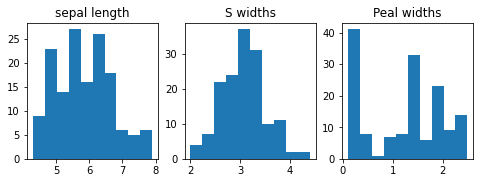

In [8]:
#Look at the data
plt.figure(figsize=(8, 2.5)); ax=plt.subplot(131)
plt.hist(iris['sepal_length']); plt.title('sepal length');
ax=plt.subplot(132)
plt.hist(iris['sepal_width']); plt.title('S widths')
ax=plt.subplot(133)
plt.hist(iris['petal_width']); plt.title('Peal widths')

In [9]:
#Set up target vector
petal_widths = iris['petal_width']

#Create linear reg model
model = LinearRegression(fit_intercept=True)

#Fit the model
model.fit(sepal_feats, petal_widths)
print(model.coef_)
print(model.intercept_)

[ 0.723292   -0.47872132]
-1.5634922663066062


In [10]:
#get model score
model.score(sepal_feats, petal_widths)

0.7429280023779846

In [11]:
#Get model predictions
petal_preds = model.predict(sepal_feats)

Text(0, 0.5, 'Actual Width')

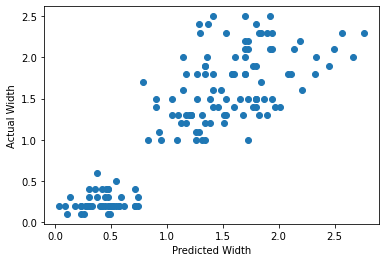

In [12]:
#plot the results
plt.figure()
plt.scatter(petal_preds, petal_widths)
plt.xlabel('Predicted Width'); plt.ylabel('Actual Width')

In [13]:
import statsmodels.api as sm

X2 = sm.add_constant(sepal_feats)

model2 = sm.OLS(petal_widths, X2)
model_fit = model2.fit()

print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            petal_width   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     212.4
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           4.36e-44
Time:                        09:47:54   Log-Likelihood:                -69.735
No. Observations:                 150   AIC:                             145.5
Df Residuals:                     147   BIC:                             154.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5635      0.339     -4.611   

**Exercise: How does the ROC curve/AUC change as a function of the penalty parameter?**

In [19]:
Cs = np.logspace(np.log10(1e-10), np.log10(1e1), num=12)

aucs = []

for c in Cs:
    lr_classifier = LogisticRegression(C=c, penalty='l2', class_weight='balanced', solver='liblinear')
    lr_classifier.fit(pow_feats, recalled)
    
    recall_prob_array = lr_classifier.predict_proba(pow_feats)[:,1]
    auc = roc_auc_score(recalled, recall_prob_array)
    
    aucs.append(auc)

Text(0, 0.5, 'AUC')

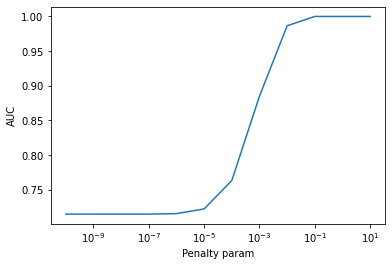

In [21]:
plt.figure()
plt.plot(Cs, aucs)
plt.xscale('log')
plt.xlabel('Penalty param'); plt.ylabel('AUC')

**Exercise: Randomly select a subset of features from the feature matrix, and recompute the AUC. How does AUC change as a function of the number of features?**

In [22]:
n_feats = np.logspace(np.log10(1), np.log10(1000), num=7)

n_perms = 100

aucs = []

for n_feat in n_feats:
    
    aucs_ = []
    
    for iPerm in range(n_perms):
        
        lr_classifier = LogisticRegression(C=0.0001, penalty='l2', class_weight='balanced', solver='liblinear')
        pow_feats_ = pow_feats[:, np.random.permutation(np.arange(pow_feats.shape[1]))[:n_feat.astype(int)]]
        lr_classifier.fit(pow_feats_, recalled)

        recall_prob_array = lr_classifier.predict_proba(pow_feats_)[:,1]
        auc = roc_auc_score(recalled, recall_prob_array)
        
        aucs_.append(auc)
        
    aucs.append(np.mean(aucs_))
    

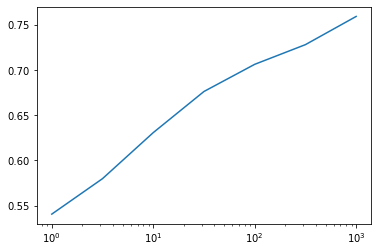

In [23]:
plt.figure()
plt.plot(n_feats, aucs)
plt.xscale('log')

# Assignment 5
In this assignment, you will estimate the exponent of the power law for more electrodes in R1111M. 
1. Select the first 50 electrodes and computes spectral power using Morlet wavelets for 30 frequencies between 3 and 150 Hz (np.logspace(np.log10(3), np.log10(150), num=30)) using buf = 1000 ms. 
2. Fit a regression of $\log(power) \sim \log(freq)$ for each electrode and obtain an estimate for $\alpha$, where $\alpha$ is the exponent in $ power \sim 1/freq^\alpha$.
3. Plot the distribution of $\alpha$ across these 50 electrodes. How consistent are the $\alpha$'s across these electrodes? 

In [1]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import mne
np.random.seed(100)

In [2]:
### Assignment 5 Solutions
from CMLLoad import CMLLoad

# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('./CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']

# Load the EEG as an mne object.
eeg = load.LoadMNE(df_sess, ev_start=-buf, ev_len=buf+1000+buf)
# Select all word events.
eeg = eeg[word_evs.index]
# Select the 62nd electrode.
eeg = eeg.pick_channels(eeg.ch_names[:50])
sr = eeg.info['sfreq'] #we'll need this soon
# Pre-define an array of frequencies.
# We can log-space them since wavelets are less sensitive to differences at higher frequencies
myfreqs = np.logspace(np.log10(3), np.log10(150), num=30)
# Run TF decomposition
# We're setting it to automatically average across trials
power = mne.time_frequency.tfr_morlet(eeg, freqs=myfreqs, n_cycles=5, return_itc=False, average=True)


765 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [3]:
log_power = np.log10(power.data[:, :, int(buf/1000.*sr):-1*int(buf/1000.*sr)])
log_power = log_power.mean(axis = 2)
log_freqs = np.log10(power.freqs)

In [4]:
alpha_vec = []
for i in range(log_power.shape[0]):
    reg = linear_model.LinearRegression()
    model = reg.fit(log_freqs.reshape(len(log_freqs),1), log_power[i,:])
    b_est = model.coef_[0]
    alpha_vec.append(-b_est)

Text(0.5, 0, 'alpha')

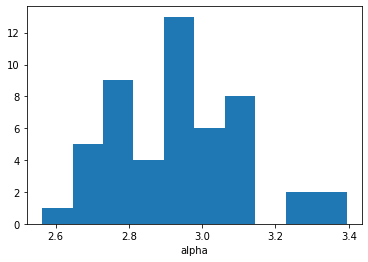

In [5]:
plt.hist(alpha_vec)
plt.xlabel('alpha')